# 1. Introduction

Recently, _Trugman & Ross_ ([2019](https://doi.org/10.1029/2019GL083725)) performed an in-depth statistical analysis of the seismicity rates preceding 46 mainshock events in Southern California employing a highly complete earthquake catalogue (the QTM catalogue; _Ross_ et al., [2019](https://doi.org/10.1126/science.aaw6888)). By comparing short-term seismicity rates with the background rate over one year prior to a selected mainshock, _Trugman & Ross_ (2019) concluded that over 70% of all analysed mainshocks were preceded by a statistically significant increase in seismicity rates. These authors further alluded to the possibility that in practically all cases foreshock sequences may be detected, provided by that the earthquake catalogue is sufficiently complete. If this claim holds true, this has the implication that the nucleation process of (large) earthquakes emits detectable information with potential application in short-term earthquake forecasting. 

In this study, we re-assess the analysis of _Trugman & Ross_ (2019), and we evaluate the impact of the assumptions made by these authors. Using an alternative statistical approach, we find that only 15 out of 46 mainshocks (33%) are preceded by significantly elevated seismicity rates. When accounting for temporal fluctuations in the background seismicity, only 18% of the analysed foreshock sequences remain unexplained by the background seismicity. These results imply that even in a highly complete earthquake catalogue, the majority of earthquakes do not exhibit detectable foreshock sequences.

This Python notebook reproduces the analysis and figures presented in _van den Ende & Ampuero_ ([EarthArxiv](https://doi.org/10.31223/osf.io/nmwkx)). We first download and read the QTM catalogue, and extract the earthquakes associated with the selected mainshock events (Section 2). These are subsequently analysed and visualised in Section 3.

# 2. Data preparation

We begin by importing the relevant Python libraries and defining I/O paths:

In [1]:
%matplotlib notebook

# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, truncnorm, poisson
from scipy.optimize import fmin
import pandas as pd
import os

# Define data paths
data_dir = "data"
data_url = "https://service.scedc.caltech.edu/ftp/QTMcatalog/qtm_final_9.5dev.hypo"
data_file = os.path.join(data_dir, "data_selection.h5")

# Background seismicity rate estimates (from Trugman & Ross, 2019)
param_file = os.path.join(data_dir, "background_rate_params")

The [QTM catalogue](https://scedc.caltech.edu/research-tools/QTMcatalog.html) is downloaded from the Southern California Earthquake Data Center (doi:[10.7909/C3WD3xH1](https://doi.org/10.7909/C3WD3xH1)). Note that the ASCII catalogue size is over 200 Mb, so that this step may take a while depending on the internet connection. The data is read into a Pandas dataframe and the first 10 rows are inspected:

In [2]:
# Read the data
data = pd.read_csv(data_url, header=0, delim_whitespace=True)
data = data.infer_objects()

# Check the first 10 entries
data.head(10)

,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,EVENTID,LATITUDE,LONGITUDE,DEPTH,MAGNITUDE,MAGP5,MAGP95,TEMPLATEID,STACKCC,MAD,RELOCATED?
0,2008,1,1,0,1,31.150,1,36.00636,-117.80533,1.694,-0.33,-0.65,0.09,14234568,0.260,0.022,0
1,2008,1,1,0,4,12.531,2,33.26719,-116.28997,11.567,0.78,0.59,0.90,37614600,0.348,0.026,1
2,2008,1,1,0,4,18.539,3,33.45944,-116.58639,10.438,0.37,0.27,0.48,10310729,0.515,0.018,1
3,2008,1,1,0,7,32.377,4,33.59068,-116.63390,13.378,0.38,0.28,0.47,37190560,0.404,0.017,1
4,2008,1,1,0,13,35.803,5,33.49738,-116.57621,7.997,-0.27,-0.41,-0.13,10297685,0.182,0.018,1
5,2008,1,1,0,22,29.550,6,33.01875,-115.54154,3.051,1.16,0.91,1.45,14899380,0.138,0.014,0
6,2008,1,1,0,38,37.090,7,33.26227,-115.97375,5.059,-0.28,-0.80,0.17,14465968,0.181,0.019,0
7,2008,1,1,0,50,15.505,8,34.29315,-116.88656,6.975,0.75,0.58,0.95,37668024,0.284,0.025,1
8,2008,1,1,0,58,21.470,9,33.49449,-116.49099,11.813,-0.06,-0.21,0.13,15538681,0.147,0.014,1
9,2008,1,1,0,58,57.842,10,33.49528,-116.49165,11.818,0.05,-0.10,0.18,15538673,0.216,0.014,1


The `EVENTID`s of the mainshocks are taken from Supplementary Table S1 in _Trugman & Ross_ (2019):

In [3]:
main_events = np.array([
    14383980, 15200401, 37374687, 15481673, 14408052, 15296281, 10410337, 15520985, 15189073, 10370141, 
    14601172, 11413954, 10527789, 15476961, 37507576, 15475329, 37510616, 14418600, 14898996, 37526424, 
    15447161, 11339042, 11373458, 10530013, 14571828, 37301704, 11001205, 14600292, 37298672, 10321561, 
    15226257, 15507801, 11006189, 14396336, 10489253, 15223417, 37299263, 15014900, 14403732, 15071220, 
    37166079, 14406304, 37644544, 15153497, 15267105, 37243591
])

Precompute quantities related to the epicentral distance (assuming a spherical Earth):

In [4]:
d_max = 10.0e3                   # Max epicentral distance [m]
R_earth = 6371.0e3               # Radius of the Earth [m]

# Convert (latitude, longitude) to radians
lat_lon_rad = data[["LATITUDE", "LONGITUDE"]] * np.pi / 180.0

Loop over all mainshocks, select all events within a 20x20 km box around each mainshock, and append to a `DataFrame`:

In [5]:
# Prepare a dataframe to contain the extracted data
key_dict = {
    "ID": "EVENTID",
    "mainID": "MAINID",
    "year": "YEAR",
    "month": "MONTH",
    "day": "DAY",
    "hour": "HOUR",
    "minute": "MINUTE",
    "second": "SECOND",
    "t_sec": "t_sec",
    "lat": "LATITUDE",
    "lon": "LONGITUDE",
    "depth": "DEPTH",
    "Mw": "MAGNITUDE"
}
extract_data = pd.DataFrame(columns=key_dict.keys())

# Loop over all mainshock events
for n, event in enumerate(main_events):
    
    print("Processing event %d (ID: #%d)" % (n+1, event))
    
    # Select the mainshock data
    event_data = data.loc[data["EVENTID"] == event]
    # Convert latitude/longitude to radians
    lat0, lon0 = event_data[["LATITUDE", "LONGITUDE"]].values[0] * np.pi / 180.0
    cos_lat0 = np.cos(lat0)
    
    x = R_earth * (lat_lon_rad["LONGITUDE"] - lon0) * cos_lat0
    y = R_earth * (lat_lon_rad["LATITUDE"] - lat0)
    
    # Select the events for which the epicentral distance is less than R_max
    inds = (np.abs(x) <= d_max) & (np.abs(y) <= d_max)
    sub_events = data.loc[inds].copy()
    
    # Convert the catalogue datetime to Python datetime
    event_dt = pd.to_datetime(sub_events[["YEAR", "MONTH", "DAY", "HOUR", "MINUTE"]])
    # Compute time (in seconds) relative to first event in the catalogue extract
    t_sec = (event_dt - event_dt.iloc[0]).dt.total_seconds().values
    
    # Add relative time and mainshock ID to the dataframe
    sub_events["t_sec"] = t_sec
    sub_events["MAINID"] = np.ones(len(sub_events), dtype=int) * event
    
    # Get the column names to be included in the new database
    sub_cols = [val for _, val in key_dict.items()]
    sub_events = sub_events[sub_cols]
    # Rename the column names
    sub_events.columns = key_dict.keys()
    # Append the data
    extract_data = extract_data.append(sub_events)

print("Done")

Processing event 1 (ID: #14383980)
Processing event 2 (ID: #15200401)
Processing event 3 (ID: #37374687)
Processing event 4 (ID: #15481673)
Processing event 5 (ID: #14408052)
Processing event 6 (ID: #15296281)
Processing event 7 (ID: #10410337)
Processing event 8 (ID: #15520985)
Processing event 9 (ID: #15189073)
Processing event 10 (ID: #10370141)
Processing event 11 (ID: #14601172)
Processing event 12 (ID: #11413954)
Processing event 13 (ID: #10527789)
Processing event 14 (ID: #15476961)
Processing event 15 (ID: #37507576)
Processing event 16 (ID: #15475329)
Processing event 17 (ID: #37510616)
Processing event 18 (ID: #14418600)
Processing event 19 (ID: #14898996)
Processing event 20 (ID: #37526424)
Processing event 21 (ID: #15447161)
Processing event 22 (ID: #11339042)
Processing event 23 (ID: #11373458)
Processing event 24 (ID: #10530013)
Processing event 25 (ID: #14571828)
Processing event 26 (ID: #37301704)
Processing event 27 (ID: #11001205)
Processing event 28 (ID: #14600292)
P

Write the extracted data to disk (in HDF5 format):

In [6]:
# Replace the index with event ID
extract_data.set_index("ID", drop=True, inplace=True)
# Assess dtypes
extract_data = extract_data.infer_objects()
# Export data to HDF format
extract_data.to_hdf(data_file, key="data", mode="w",complevel=9, complib="blosc", format="fixed")

# 3. Analysis

Define constants in the analysis that follows:

In [7]:
t_day = 3600 * 24.0   # Number of seconds per day
t_win = 20 * t_day    # Time window for analysis (20 days) [s]
dt = 1 * t_day        # Stride of sliding window [s]
N_samples = 50_000    # Number of samples for Monte-Carlo sampling
p_crit = 0.01         # Significance criterion

Read the extracted data and inversion results from _Trugman & Ross_ (2019):

In [8]:
# Data extracted from QTM
data = pd.read_hdf(data_file)
# Inversion results
inv_data = pd.read_csv(param_file, header=None, names=("ID", "mu", "y"), delimiter=",")

## Random sampling

For each mainshock, we collect the associated earthquakes, and estimate the background seismicity rate by fitting a gamma distribution. We then render 50,000 realisations of this distribution to assess the probability distribution of observing $N_{eq}$ events over a time span (`t_win`) of 20 days.

In [9]:
# Instantiate dictionary to store results
sampling_dict = {}

# Loop over all mainshock events
for n, event in enumerate(main_events):
    
    print("Event %d (ID %d)" % (n+1, event))
    
    # Select mainshock and associated events
    event_data = data.loc[(data.index == event) & (data["mainID"] == event)]
    sub_events = data.loc[data["mainID"] == event]
    
    # Get relative timing of events
    t_sec = sub_events["t_sec"].values
    t_main_sec = event_data["t_sec"].values
    
    # Data range: all events between -380 < t < -20 days (mainshock at t = 0)
    inds_prior = (t_sec < t_main_sec - 20 * t_day) & (t_sec > t_main_sec - 380 * t_day)
    
    """ Estimate background seismicity rate based on interevent times (IET) """
    # Compute interevent times
    IET = (t_sec[inds_prior][1:] - t_sec[inds_prior][:-1]).astype(int)
    IET = IET / t_day
    # Indices of non-simultaneous events
    inds = (IET > 0)
    
    # Estimate the background rate and shape factor by fitting a gamma distribution to the IET data
    # Note that "mu" resulting from the inversion is 1/"mu" defined by Trugman & Ross
    # mu is expressed in units of days
    y, _, mu = gamma.fit(IET[inds], floc=0.0)
    
    # Read the background rate parameters estimated by Trugman & Ross
    mu2, y2 = inv_data[inv_data["ID"] == event][["mu", "y"]].values[0]
    # Uncomment the next line to use the parameter estimates by Trugman & Ross
    # mu, y = 1.0 / mu2, y2
    
    """ Sample gamma distribution to get a distribution of the number of events observed in t_win """
    # Buffer for the number of earthquakes observed in each random sample
    N_eq = np.zeros(N_samples, dtype=int)
    
    # Loop over N random samples
    for i in range(N_samples):
        # Generate a random IET sample with 200 events
        prev_size = 200
        # Sample from gamma distribution
        IET2 = gamma.rvs(a=y, loc=0, scale=mu, size=prev_size) * t_day
        # Random shift of timing of first event
        t0 = np.random.rand() * IET2[0]
        # Cumulative sum of interevent times
        t_sum = np.cumsum(IET2) - t0
        # Find the events that lie outside t_win
        inds = (t_sum > t_win)
        # If no events lie outside t_win, create a bigger sample
        while (inds.sum() == 0):
            # Generate a bigger random sample and stack with previous sample
            prev_size *= 2
            IET2 = np.hstack([IET2, gamma.rvs(a=y, loc=0, scale=mu, size=prev_size) * t_day])
            # Cumulative sum of event times
            t_sum = np.cumsum(IET2)
            # Find the events that lie outside t_win
            inds = (t_sum > t_win)
        # Store the number of events that lie within t_win (excluding shifted event)
        N_eq[i] = (~inds).sum() - 1
    
    """ Fit a new gamma distribution to the distribution of the number of events within t_win """
    inds = (N_eq > 0)
    y_N, _, mu_N = gamma.fit(N_eq[inds], floc=0.0)
    
    # Store relevant results in a dictionary
    sub_dict = {
        "IET": IET,
        "N_eq": N_eq,
        "gamma_params": (y, 0, mu),
        "gamma_N_params": (y_N, 0, mu_N)
    }
    sampling_dict[event] = sub_dict

print("Done")

Event 1 (ID 14383980)
Event 2 (ID 15200401)
Event 3 (ID 37374687)
Event 4 (ID 15481673)
Event 5 (ID 14408052)
Event 6 (ID 15296281)
Event 7 (ID 10410337)
Event 8 (ID 15520985)
Event 9 (ID 15189073)
Event 10 (ID 10370141)
Event 11 (ID 14601172)
Event 12 (ID 11413954)
Event 13 (ID 10527789)
Event 14 (ID 15476961)
Event 15 (ID 37507576)
Event 16 (ID 15475329)
Event 17 (ID 37510616)
Event 18 (ID 14418600)
Event 19 (ID 14898996)
Event 20 (ID 37526424)
Event 21 (ID 15447161)
Event 22 (ID 11339042)
Event 23 (ID 11373458)
Event 24 (ID 10530013)
Event 25 (ID 14571828)
Event 26 (ID 37301704)
Event 27 (ID 11001205)
Event 28 (ID 14600292)
Event 29 (ID 37298672)
Event 30 (ID 10321561)
Event 31 (ID 15226257)
Event 32 (ID 15507801)
Event 33 (ID 11006189)
Event 34 (ID 14396336)
Event 35 (ID 10489253)
Event 36 (ID 15223417)
Event 37 (ID 37299263)
Event 38 (ID 15014900)
Event 39 (ID 14403732)
Event 40 (ID 15071220)
Event 41 (ID 37166079)
Event 42 (ID 14406304)
Event 43 (ID 37644544)
Event 44 (ID 1515349

## Visualisation

To assess the quality of the fitting, the `IET` distributions are plotted for each mainshock, along with their best-fit solutions (obtained in this study and by Trugman & Ross):

<IPython.core.display.Javascript object>


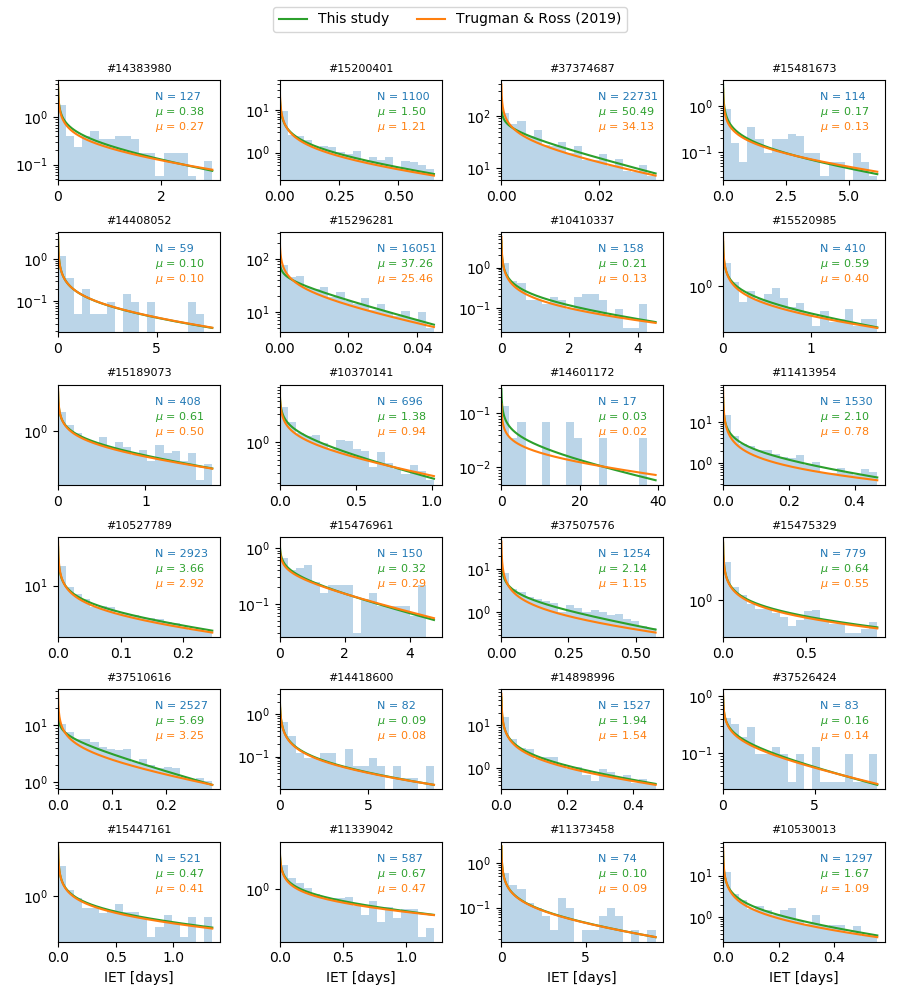

<IPython.core.display.Javascript object>


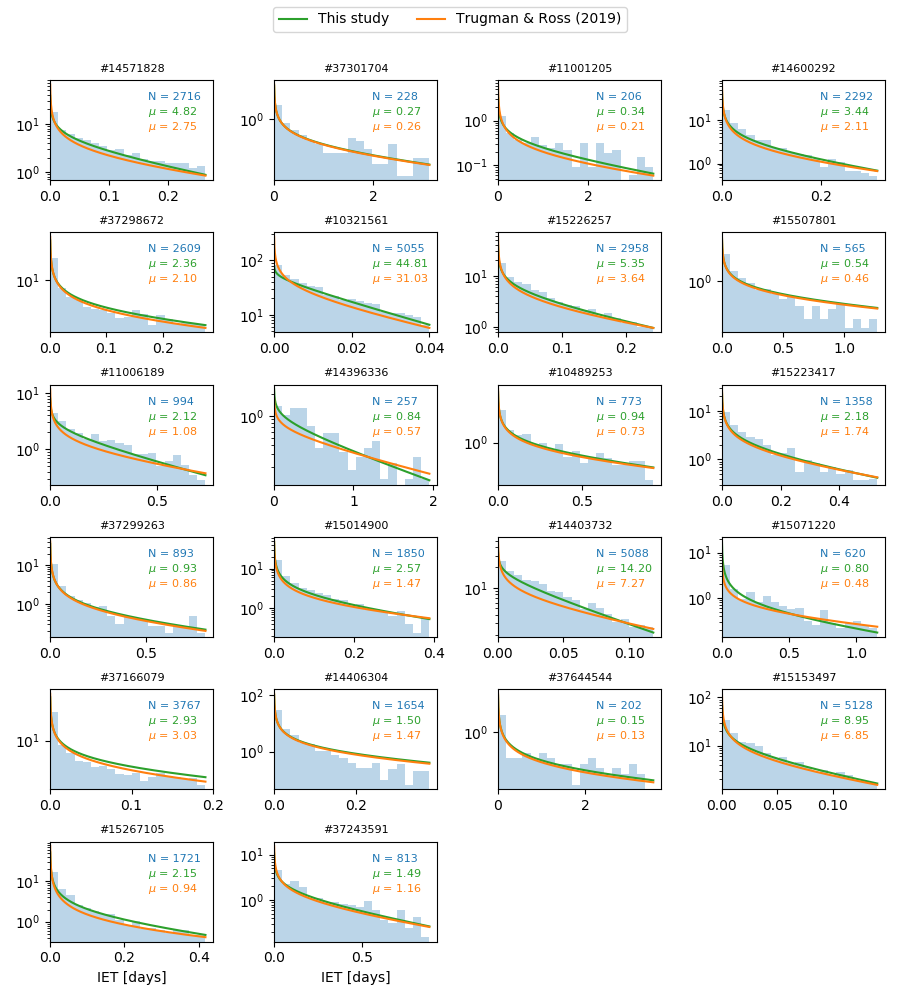

In [10]:
# Plot data over two figures
fig1, axes1 = plt.subplots(nrows=6, ncols=4, figsize=(9, 10))
fig2, axes2 = plt.subplots(nrows=6, ncols=4, figsize=(9, 10))

# First figure has 24 panels
cut = 24

# Loop over all mainshocks
for n, event in enumerate(main_events):
    event_dict = sampling_dict[event]
    
    # Select panel (axis)
    if n < cut:
        i = n // 4
        j = n % 4
        ax = axes1[i, j]
    else:
        i = (n - cut) // 4
        j = (n - cut) % 4        
        ax = axes2[i, j]
    
    # Get IET distributions
    IET = event_dict["IET"]
    inds = (IET > 0)
    
    # Best fit (this study)
    tau = np.linspace(0, 2*IET[inds].mean(), 1000)
    rho = gamma.pdf(tau, *event_dict["gamma_params"])
    
    # Best fit (Trugman & Ross)
    mu2, y2 = inv_data[inv_data["ID"] == event][["mu", "y"]].values[0]
    mu2 = 1.0 / mu2
    rho2 = gamma.pdf(tau, a=y2, loc=0, scale=mu2)
    
    # Plot histogram of IET
    ax.hist(IET[inds], bins=np.linspace(0, 2*IET[inds].mean(), 20), density=True, rwidth=1.0, alpha=0.3)
    # Plot best-fit solutions
    ax.plot(tau, rho, "C2-")
    ax.plot(tau, rho2, "C1-")
    # Indicate sample size and background rates in each panel
    ax.text(x=0.6, y=0.80, s=r"N = %d" % (len(IET[inds])), 
            transform=ax.transAxes, fontsize=8, color="C0")
    ax.text(x=0.6, y=0.65, s=r"$\mu$ = %.2f" % (1/event_dict["gamma_params"][2]), 
            transform=ax.transAxes, fontsize=8, color="C2")
    ax.text(x=0.6, y=0.50, s=r"$\mu$ = %.2f" % (1.0 / mu2), 
            transform=ax.transAxes, fontsize=8, color="C1")
    ax.set_yscale("log")
    ax.set_title("#%d" % event, fontsize=8)
    ax.set_xlim(xmin=0)

# Set x-axis labels
for j, ax in enumerate(axes1[-1]):
    ax.set_xlabel("IET [days]")

# Add legend to top of the figure
l1, = ax.plot([], [], "C2-")
l2, = ax.plot([], [], "C1-")
fig1.tight_layout()
fig1.subplots_adjust(top=0.92)
fig1.legend(handles=[l1, l2], labels=["This study", "Trugman & Ross (2019)"], loc="upper center", ncol=2)
fig1.savefig("IET_distr_all1.pdf")

# Repeat for the second figure
for j, ax in enumerate(axes2[-1]):
    ax.set_xlabel("IET [days]")

l1, = ax.plot([], [], "C2-")
l2, = ax.plot([], [], "C1-")
fig2.tight_layout()
fig2.subplots_adjust(top=0.92)
fig2.legend(handles=[l1, l2], labels=["This study", "Trugman & Ross (2019)"], loc="upper center", ncol=2)
fig2.delaxes(axes2[-1, -2])
fig2.delaxes(axes2[-1, -1])
fig2.savefig("IET_distr_all2.pdf")

plt.show()

The results from the random sampling of the gamma distributions are plotted below. The number of earthquakes $N$ observed in a 20-day time window follows a gamma distribution (best-fit solution as indicated). For reference, the Poisson distribution as assumed by _Trugman & Ross_ (2019) is plotted alongside the gamma distributions.

<IPython.core.display.Javascript object>


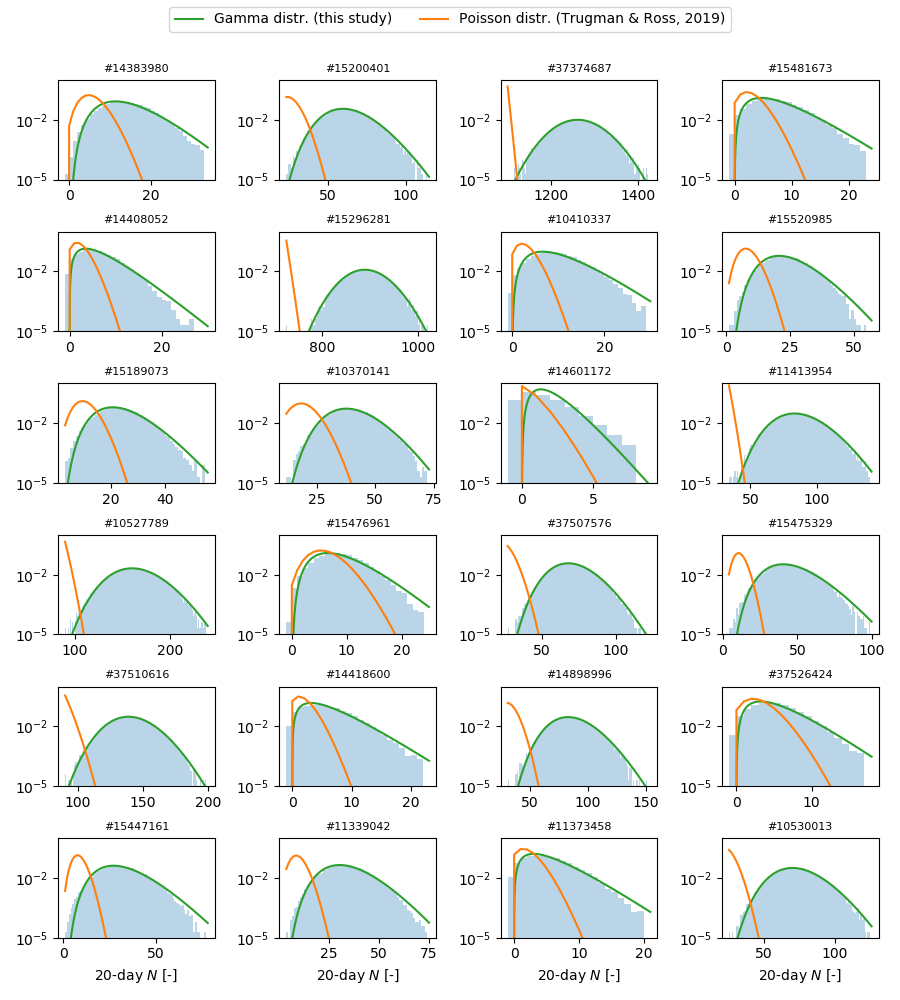

<IPython.core.display.Javascript object>


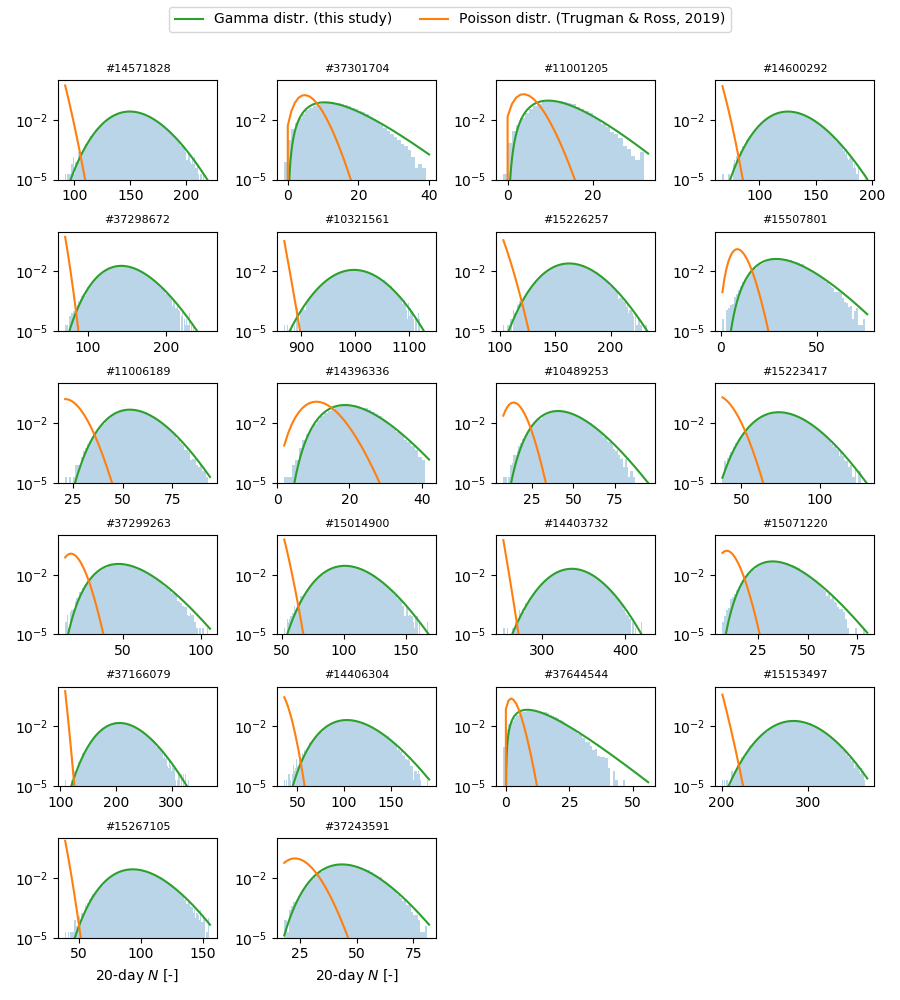

In [11]:
# Plot data over two figures
fig1, axes1 = plt.subplots(nrows=6, ncols=4, figsize=(9, 10))
fig2, axes2 = plt.subplots(nrows=6, ncols=4, figsize=(9, 10))

# First figure has 24 panels
cut = 24

# Loop over all mainshocks
for n, event in enumerate(main_events):
    event_dict = sampling_dict[event]
    
    # Select panel (axis)
    if n < cut:
        i = n // 4
        j = n % 4
        ax = axes1[i, j]
    else:
        i = (n - cut) // 4
        j = (n - cut) % 4        
        ax = axes2[i, j]
    
    """ Plot N_eq distribution """
    N_eq = event_dict["N_eq"]
    x = np.linspace(N_eq.min(), N_eq.max(), 1000)
    rho = gamma.pdf(x, *event_dict["gamma_N_params"])   
    
    # Poisson distribution based on the background rate estimated by Trugman & Ross
    mu2, y2 = inv_data[inv_data["ID"] == event][["mu", "y"]].values[0]
    x2 = np.arange(N_eq.min(), N_eq.max())
    poiss = poisson.pmf(x2, mu=mu2*t_win/t_day)
    poiss /= np.trapz(poiss)
    
    # Gamma-sampled distribution
    ax.hist(N_eq, bins=np.arange(N_eq.min(), N_eq.max()), density=True, rwidth=1.0, alpha=0.3, fc="C0")
    # Best-fit gamma distribution
    ax.plot(x, rho, "C2-")
    # Poisson distribution (Trugman & Ross)
    ax.plot(x2, poiss, "C1-")
    ax.set_yscale("log")
    ax.set_ylim((1e0, 1e-5))
    ax.set_title("#%d" % event, fontsize=8)

# Set x-axis labels
for j, ax in enumerate(axes1[-1]):
    ax.set_xlabel("20-day $N$ [-]")

# Add legend to top of the figure
l1, = ax.plot([], [], "C2-")
l2, = ax.plot([], [], "C1-")
fig1.tight_layout()
fig1.subplots_adjust(top=0.92)
fig1.legend(handles=[l1, l2], labels=["Gamma distr. (this study)", "Poisson distr. (Trugman & Ross, 2019)"], loc="upper center", ncol=2)
fig1.savefig("EQ_rate_distr_all1.pdf")

# Repeat for the second figure
for j, ax in enumerate(axes2[-1]):
    ax.set_xlabel("20-day $N$ [-]")

l1, = ax.plot([], [], "C2-")
l2, = ax.plot([], [], "C1-")
fig2.tight_layout()
fig2.subplots_adjust(top=0.92)
fig2.legend(handles=[l1, l2], labels=["Gamma distr. (this study)", "Poisson distr. (Trugman & Ross, 2019)"], loc="upper center", ncol=2)
fig2.delaxes(axes2[-1, -2])
fig2.delaxes(axes2[-1, -1])
fig2.savefig("EQ_rate_distr_all2.pdf")

plt.show()

We highlight four mainshock events as examples for the discussion:

<IPython.core.display.Javascript object>


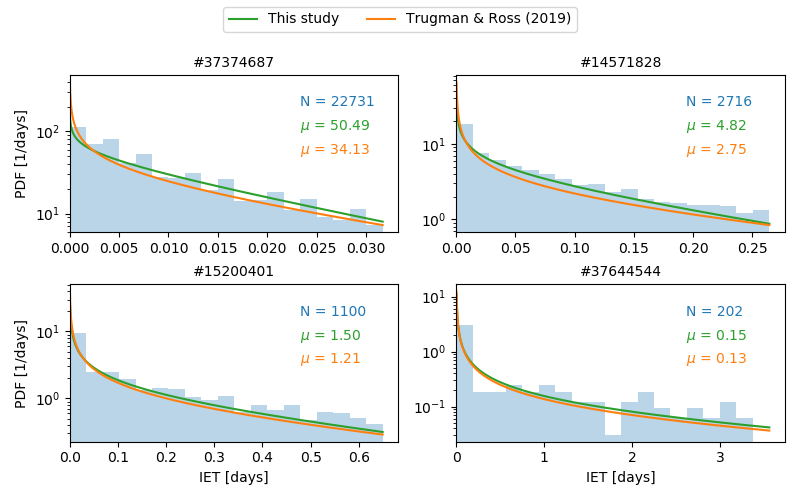

<IPython.core.display.Javascript object>


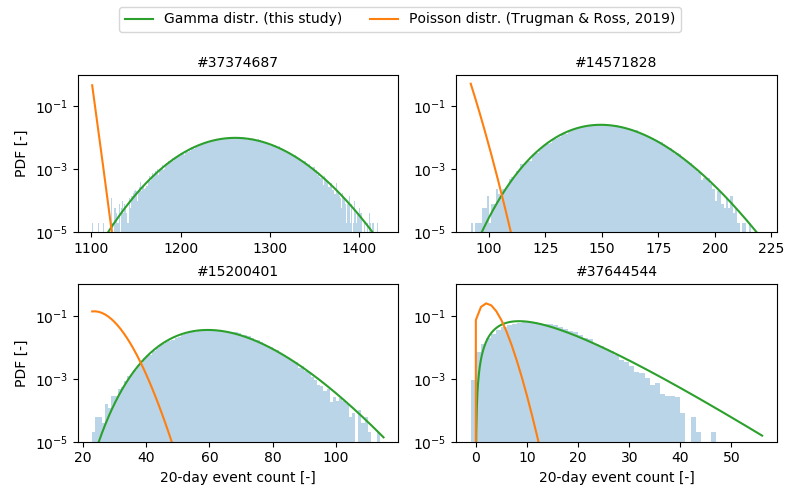

In [12]:
selected_events = [37374687, 14571828, 15200401, 37644544]

# Plot data over two figures
fig1, axes1 = plt.subplots(nrows=2, ncols=2, figsize=(8, 5))
fig2, axes2 = plt.subplots(nrows=2, ncols=2, figsize=(8, 5))

# Loop over all mainshocks
for n, event in enumerate(selected_events):
    event_dict = sampling_dict[event]
    
    # Select panel (axis)
    i = n // 2
    j = n % 2
    
    # Get IET distributions
    IET = event_dict["IET"]
    inds = (IET > 0)
    
    """ Plot IET distribution """
    # Best fit (this study)
    tau = np.linspace(0, 2*IET[inds].mean(), 1000)
    rho = gamma.pdf(tau, *event_dict["gamma_params"])
    
    # Best fit (Trugman & Ross)
    mu2, y2 = inv_data[inv_data["ID"] == event][["mu", "y"]].values[0]
    mu2 = 1.0 / mu2
    rho2 = gamma.pdf(tau, a=y2, loc=0, scale=mu2)
    
    ax = axes1[i, j]
    # Plot histogram of IET
    ax.hist(IET[inds], bins=np.linspace(0, 2*IET[inds].mean(), 20), density=True, rwidth=1.0, alpha=0.3)
    # Plot best-fit solutions
    ax.plot(tau, rho, "C2-")
    ax.plot(tau, rho2, "C1-")
    # Indicate sample size and background rates in each panel
    ax.text(x=0.7, y=0.80, s=r"N = %d" % (len(IET[inds])), 
            transform=ax.transAxes, fontsize=10, color="C0")
    ax.text(x=0.7, y=0.65, s=r"$\mu$ = %.2f" % (1/event_dict["gamma_params"][2]), 
            transform=ax.transAxes, fontsize=10, color="C2")
    ax.text(x=0.7, y=0.50, s=r"$\mu$ = %.2f" % (1.0 / mu2), 
            transform=ax.transAxes, fontsize=10, color="C1")
    ax.set_yscale("log")
    ax.set_title("#%d" % event, fontsize=10)
    ax.set_xlim(xmin=0)
    
    """ Plot N_eq distribution """
    N_eq = event_dict["N_eq"]
    x = np.linspace(N_eq.min(), N_eq.max(), 1000)
    rho = gamma.pdf(x, *event_dict["gamma_N_params"])   
    
    # Poisson distribution based on the background rate estimated by Trugman & Ross
    mu2, y2 = inv_data[inv_data["ID"] == event][["mu", "y"]].values[0]
    x2 = np.arange(N_eq.min(), N_eq.max())
    poiss = poisson.pmf(x2, mu=mu2*t_win/t_day)
    poiss /= np.trapz(poiss)
    
    ax = axes2[i, j]
    # Gamma-sampled distribution
    ax.hist(N_eq, bins=np.arange(N_eq.min(), N_eq.max()), density=True, rwidth=1.0, alpha=0.3, fc="C0")
    # Best-fit gamma distribution
    ax.plot(x, rho, "C2-")
    # Poisson distribution (Trugman & Ross)
    ax.plot(x2, poiss, "C1-")
    ax.set_yscale("log")
    ax.set_ylim((1e0, 1e-5))
    ax.set_title("#%d" % event, fontsize=10)

# Set axes labels
for i, ax in enumerate(axes1[:, 0]):
    ax.set_ylabel("PDF [1/days]")
    
for j, ax in enumerate(axes1[-1]):
    ax.set_xlabel("IET [days]")
    
# Add legend to top of the figure
l1, = ax.plot([], [], "C2-")
l2, = ax.plot([], [], "C1-")
fig1.tight_layout()
fig1.subplots_adjust(top=0.85)
fig1.legend(handles=[l1, l2], labels=["This study", "Trugman & Ross (2019)"], loc="upper center", ncol=2)
fig1.savefig("IET_distr_select.pdf")

# Repeat for the second figure
for i, ax in enumerate(axes2[:, 0]):
    ax.set_ylabel("PDF [-]")
    
for j, ax in enumerate(axes2[-1]):
    ax.set_xlabel("20-day event count [-]")

l1, = ax.plot([], [], "C2-")
l2, = ax.plot([], [], "C1-")
fig2.tight_layout()
fig2.subplots_adjust(top=0.85)
fig2.legend(handles=[l1, l2], labels=["Gamma distr. (this study)", "Poisson distr. (Trugman & Ross, 2019)"], loc="upper center", ncol=2)
fig2.savefig("EQ_rate_distr_select.pdf")

plt.show()

We next compare the survival functions of the gamma distribution (this study) and the Poisson distribution (Trugman & Ross), and plot the time series of earthquake occurrences for visual reference:

<IPython.core.display.Javascript object>


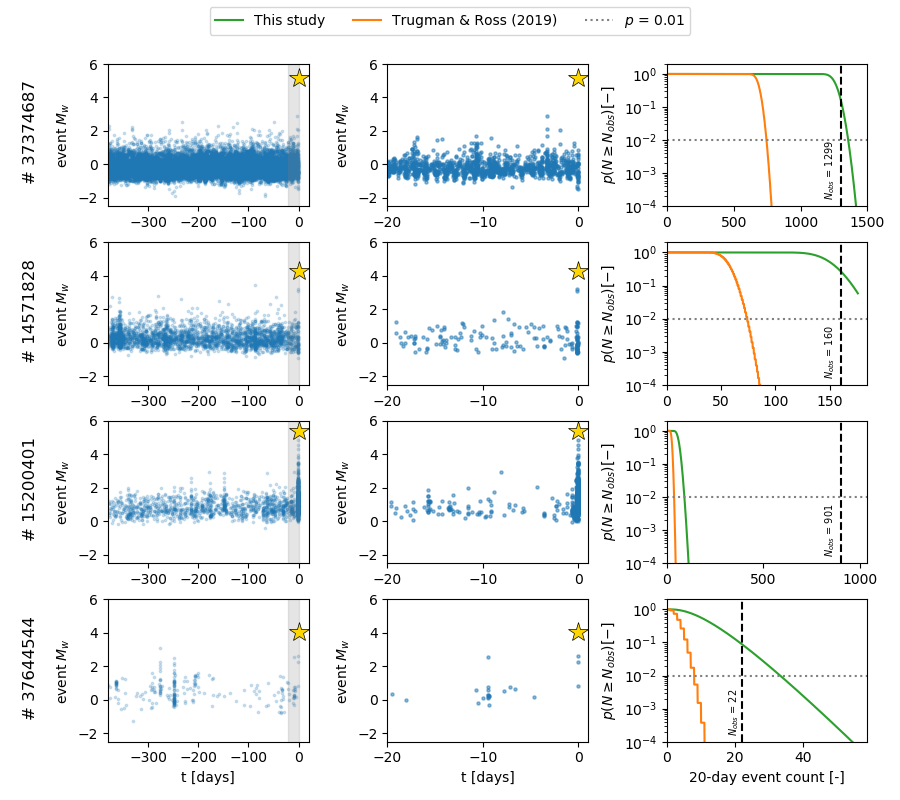

In [13]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(9, 8))

# Loop over all mainshocks
for n, event in enumerate(selected_events):
    event_data = data.loc[(data.index == event) & (data["mainID"] == event)]
    sub_events = data.loc[data["mainID"] == event]
    event_dict = sampling_dict[event]
    
    # Get the relative timing of events
    t_sec = sub_events["t_sec"].values
    t_main_sec = event_data["t_sec"].values[0]
    Mw_main = event_data["Mw"].values[0]
    
    # Select the events 20 days prior to the mainshock
    inds_prior = (t_sec > t_main_sec - t_win) & (t_sec < t_main_sec)
    inds_year = (t_sec > t_main_sec - 380 * t_day) & (t_sec < t_main_sec)
    # Observed number of events in this time interval
    N_obs = inds_prior.sum()
    
    # Timing and magnitude of the seismicity over 1 year
    t_sec_year = t_sec[inds_year]
    Mw_year = sub_events["Mw"].iloc[inds_year]
    
    # Timing and magnitude of the seismicity prior to the mainshock
    t_sec = t_sec[inds_prior]
    Mw = sub_events["Mw"].iloc[inds_prior]
    
    # Parameter estimates from Trugman & Ross
    mu2, y2 = inv_data[inv_data["ID"] == event][["mu", "y"]].values[0]
    
    """ Plot 1-year event sequence (Mw vs. time) """    
    # Plot earthquake sequence
    ax = axes[n, 0]
    rect = plt.Rectangle((-20, -3), 20, 10, color="gray", alpha=0.2)
    ax.add_patch(rect)
    ax.scatter((t_sec_year - t_main_sec) / t_day, Mw_year, s=3, c="C0", alpha=0.2)
    ax.plot(0, Mw_main, "*", c="gold", ms=15, mew=0.5, mec="k")
    ax.set_xlim((-380, 20))
    ax.set_ylim((-2.5, 6)) 
    ax.set_ylabel(r"event $M_w$")
    
    
    """ Plot 20-day event sequence (Mw vs. time) """
    # Plot earthquake sequence
    ax = axes[n, 1]
    ax.scatter((t_sec - t_main_sec) / t_day, Mw, s=5, c="C0", alpha=0.5)
    ax.plot(0, Mw_main, "*", c="gold", ms=15, mew=0.5, mec="k")
    ax.set_xlim((-20, 1))
    ax.set_ylim((-2.5, 6))
    ax.set_ylabel(r"event $M_w$")
    
    """ Plot survival functions """
    # Gamma survival function
    x = np.linspace(0, max(N_eq.max(), 1.1*N_obs), 1000)
    P = gamma.sf(x, *event_dict["gamma_N_params"])
    
    # Poisson survival function
    x2 = np.arange(0, max(N_eq.max(), 1.1*N_obs))
    poiss = poisson.sf(x-1, mu=mu2*t_win/t_day)
    
    ax = axes[n, 2]
    ax.plot(x, P, "C2-")
    ax.plot(x, poiss, "C1-")
    ax.axvline(N_obs, ls="--", c="k")
    if n == axes.shape[0] - 1:
        ax.text(x=0.8*N_obs, y=2e-4, s=r"$N_{obs}$ = %d" % N_obs, fontsize=7, rotation=90)
    else:
        ax.text(x=0.9*N_obs, y=2e-4, s=r"$N_{obs}$ = %d" % N_obs, fontsize=7, rotation=90)
    ax.axhline(p_crit, ls=":", c="gray")
    ax.set_yscale("log")
    ax.set_ylabel(r"$p(N \geq N_{obs}) [-]$")
    ax.set_ylim((1e-4, 2e0))
    ax.set_xlim(xmin=0)

axes[-1, 0].set_xlabel("t [days]")
axes[-1, 1].set_xlabel("t [days]")
axes[-1, 2].set_xlabel("20-day event count [-]")        
    
plt.tight_layout()
plt.subplots_adjust(left=0.12, top=0.92)
for n, event in enumerate(selected_events):
    axes[n, 0].text(x=-550, y=-1, s="# %d" % event, fontsize=12, rotation=90)

l1, = ax.plot([], [], "C2-")
l2, = ax.plot([], [], "C1-")
l3, = ax.plot([], [], c="gray", ls=":")
fig.legend(handles=[l1, l2, l3], labels=["This study", "Trugman & Ross (2019)", r"$p$ = 0.01"], loc="upper center", ncol=3)
plt.savefig("p-values_select.pdf")

plt.show()

Lastly, we compute the $p$-values for each mainshock event, and print out the number of events that are preceded by a statistically significant foreshock sequence:

In [14]:
# Counter of how many earthquakes are preceded by elevated seismicity rates
foreshock_counter = 0

for n, event in enumerate(main_events):
    event_data = data.loc[(data.index == event) & (data["mainID"] == event)]
    sub_events = data.loc[data["mainID"] == event]
    event_dict = sampling_dict[event]
    
    # Get the relative timing of events
    t_sec = sub_events["t_sec"].values
    t_main_sec = event_data["t_sec"].values[0]
    Mw_main = event_data["Mw"].values[0]
    
    # Select the events 20 days prior to the mainshock
    inds_prior = (t_sec > t_main_sec - t_win) & (t_sec < t_main_sec)
    # Observed number of events in this time interval
    N_obs = inds_prior.sum()
    
    # Parameter estimates from Trugman & Ross
    mu2, y2 = inv_data[inv_data["ID"] == event][["mu", "y"]].values[0]
    
    p_val = gamma.sf(N_obs, *event_dict["gamma_N_params"])
    if p_val < p_crit:
        foreshock_counter += 1

ratio = foreshock_counter / len(main_events)
print("Mainshocks preceded by foreshocks: %d / %d (= %.2f %%)" % (foreshock_counter, len(main_events), 100*ratio))

Mainshocks preceded by foreshocks: 15 / 46 (= 32.61 %)


## Temporal fluctuations

Next, we calculate the evolution of the $p$-value over a period of up to 380 days prior to each mainshock (within sliding time window (`t_win`) of 20 days and a stride (`dt`) of 1 day):

<IPython.core.display.Javascript object>


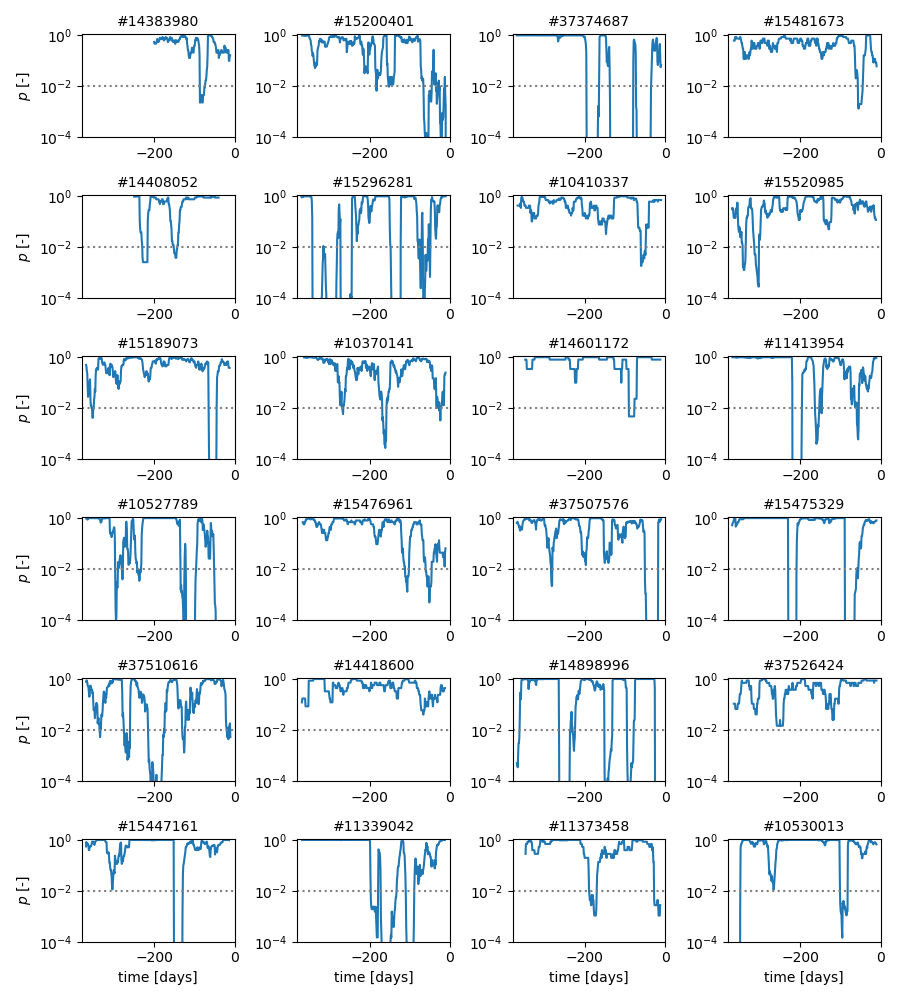

<IPython.core.display.Javascript object>


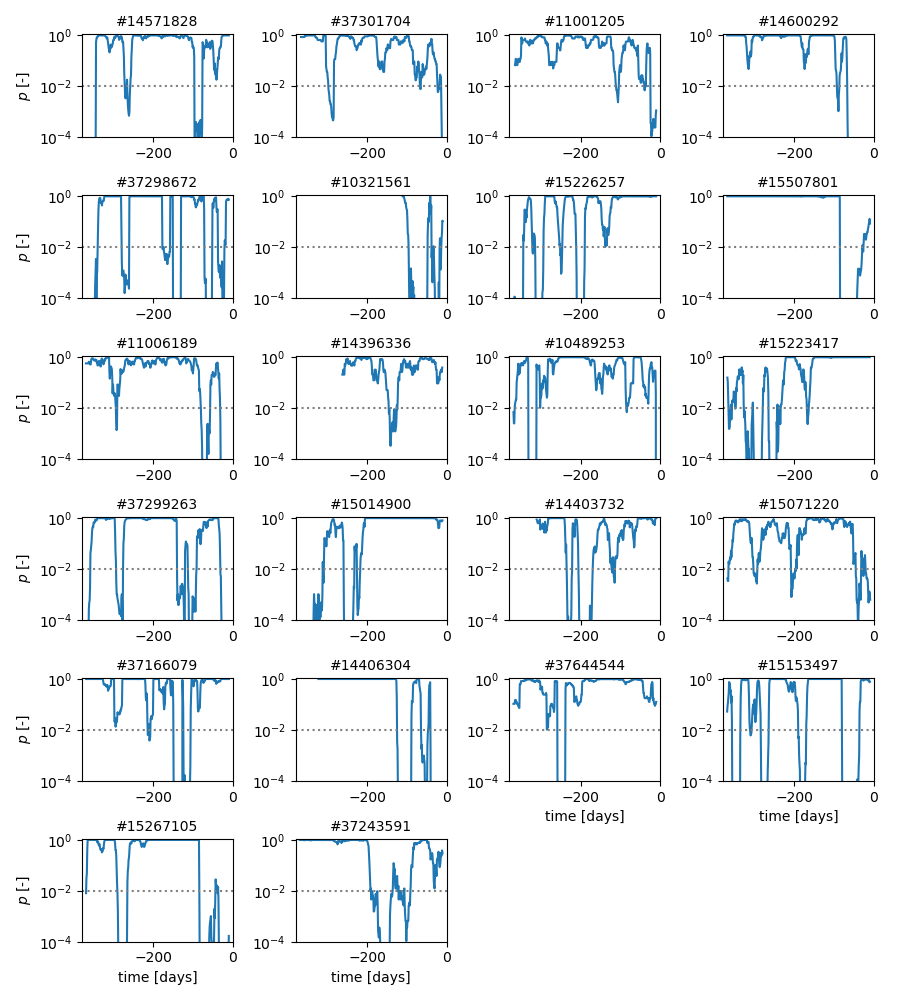

In [15]:
# Buffer for p-values for all mainshocks
p_vals_all = np.zeros((len(main_events), 2), dtype=float) * np.nan

# Plot data over two figures
fig1, axes1 = plt.subplots(nrows=6, ncols=4, figsize=(9, 10))
fig2, axes2 = plt.subplots(nrows=6, ncols=4, figsize=(9, 10))

# First figure has 24 panels
cut = 24

# Loop over all mainshocks
for n, event in enumerate(main_events):
    event_data = data.loc[(data.index == event) & (data["mainID"] == event)]
    sub_events = data.loc[data["mainID"] == event]
    event_dict = sampling_dict[event]
    
    # Select panel (axis)
    if n < cut:
        i = n // 4
        j = n % 4
        ax = axes1[i, j]
    else:
        i = (n - cut) // 4
        j = (n - cut) % 4      
        ax = axes2[i, j]
    
    # Get the relative timing of events
    t_sec = sub_events["t_sec"].values
    t_main_sec = event_data["t_sec"].values.ravel()
    # Select 380 days prior to the mainshock
    inds_prior = (t_sec > t_main_sec - 380 * t_day) & (t_sec < t_main_sec)
    t_sec = t_sec[inds_prior]    
    
    # Time windows to compute p-values
    half_win = t_win / 2
    t_splits = np.arange(t_sec.min() + half_win, t_sec.max() - half_win + dt, dt)
    t_mid = 0.5 * (t_splits[1:] + t_splits[:-1])
    
    # Buffer for p-values
    p_vals = np.zeros_like(t_splits[:-1]) * np.nan
    
    # 20-day earthquake distribution
    N_eq = event_dict["N_eq"]
    
    # Loop over all time windows
    for i, split in enumerate(t_splits[:-1]):
        # Select events within this time window
        inds = (t_sec > split - half_win) & (t_sec < split + half_win)
        # Count number of events
        N_obs = inds.sum()
        # Compute p(N > N_obs)
        p_vals[i] = gamma.sf(N_obs, *event_dict["gamma_N_params"])
    
    # Time windows that have p < p_crit
    inds_signif = (p_vals < p_crit)
    # Time windows that are not NaN
    inds_finite = np.isfinite(p_vals)
    # Store number of significant/finite time windows in buffer
    p_vals_all[n] = (inds_signif.sum(), inds_finite.sum())
    
    # Plot time evolution of p-value 380 days prior to main event
    ax.plot((t_mid - t_main_sec) / t_day, p_vals)
    ax.axhline(p_crit, ls=":", c="gray")
    ax.set_xlim((-380, 0))
    ax.set_ylim((1e-4, 1.1))
    ax.set_title("#%d" % event, fontsize=10)
    ax.set_yscale("log")
    
for ax in axes1[-1]:
    ax.set_xlabel("time [days]")
for ax in axes1[:, 0]:
    ax.set_ylabel(r"$p$ [-]")

for ax in axes2[-1]:
    ax.set_xlabel("time [days]")
for ax in axes2[:, 0]:
    ax.set_ylabel(r"$p$ [-]")

fig1.tight_layout()
fig1.savefig("p-vals_time_all1.pdf")

fig2.tight_layout()
fig2.delaxes(axes2[-1, -2])
fig2.delaxes(axes2[-1, -1])
axes2[-2, -1].set_xlabel("time [days]")
axes2[-2, -2].set_xlabel("time [days]")
fig2.savefig("p-vals_time_all2.pdf")
plt.show()
    

The seismicity rate (and associated $p$-value) is highly variable over the 380-day period prior to each mainshock. The total fraction of time windows that have a $p$-value below the significance theshold (`p_crit`) is:

In [16]:
p_mean = p_vals_all[:, 0].sum() / p_vals_all[:, 1].sum()
print("Fraction of time with p < %.2f: %.2f %%" % (p_crit, 100 * p_mean))

Fraction of time with p < 0.01: 15.61 %


Highlighting the variability of the four selected examples:

<IPython.core.display.Javascript object>


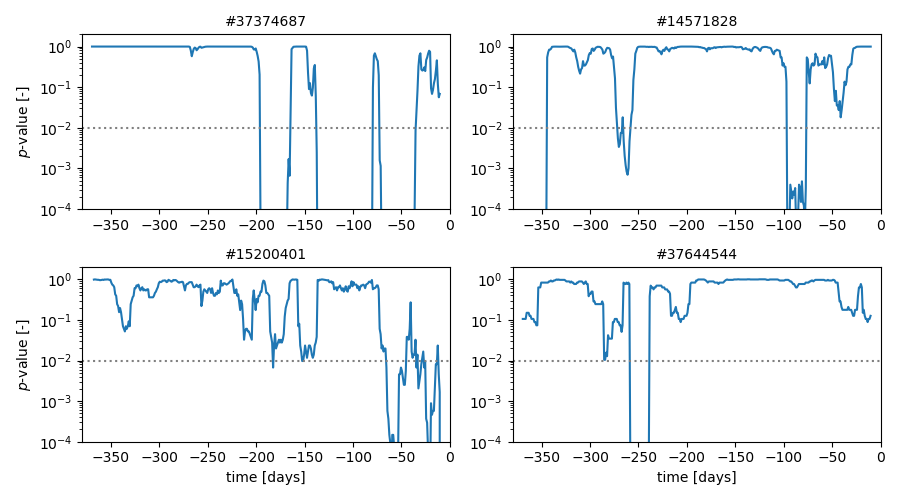

In [17]:
# Buffer for p-values for all mainshocks
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 5))

# Loop over all mainshocks
for n, event in enumerate(selected_events):
    event_data = data.loc[(data.index == event) & (data["mainID"] == event)]
    sub_events = data.loc[data["mainID"] == event]
    event_dict = sampling_dict[event]
    
    # Get the relative timing of events
    t_sec = sub_events["t_sec"].values
    t_main_sec = event_data["t_sec"].values.ravel()
    # Select 380 days prior to the mainshock
    inds_prior = (t_sec > t_main_sec - 380 * t_day) & (t_sec < t_main_sec)
    t_sec = t_sec[inds_prior]    
    
    # Time windows to compute p-values
    half_win = t_win / 2
    t_splits = np.arange(t_sec.min() + half_win, t_sec.max() - half_win + dt, dt)
    t_mid = 0.5 * (t_splits[1:] + t_splits[:-1])
    
    # Buffer for p-values
    p_vals = np.zeros_like(t_splits[:-1]) * np.nan
    
    # 20-day earthquake distribution
    N_eq = event_dict["N_eq"]
    
    # Loop over all time windows
    for i, split in enumerate(t_splits[:-1]):
        # Select events within this time window
        inds = (t_sec > split - half_win) & (t_sec < split + half_win)
        # Count number of events
        N_obs = inds.sum()
        # Compute p(N > N_obs)
        p_vals[i] = gamma.sf(N_obs, *event_dict["gamma_N_params"])
    
    # Plot time evolution of p-value 380 days prior to main event
    i = n // 2
    j = n % 2
    ax = axes[i, j]
    ax.plot((t_mid - t_main_sec) / t_day, p_vals)
    ax.axhline(p_crit, ls=":", c="gray")
    ax.set_xlim((-380, 0))
    # ax.set_ylim((-0.1, 1.1))
    ax.set_ylim((1e-4, 2e0))
    ax.set_title("#%d" % event, fontsize=10)
    
    ax.set_yscale("log")
    
axes[0, 0].set_ylabel(r"$p$-value [-]")
axes[1, 0].set_ylabel(r"$p$-value [-]")
axes[1, 0].set_xlabel("time [days]")
axes[1, 1].set_xlabel("time [days]")
    
plt.tight_layout()
plt.savefig("p-vals_time.pdf")
plt.show()

# 4. Conclusions

While the characterisation of the background seismicity rate based on the interevent time (IET) method is robust, the subsequent assumption that all earthquakes in the catalogue are statistically independent (and may therefore be described by a Poisson distribution) is overly restrictive. Consequently, the number of events expected to be observed in a 20-day time interval directly prior to a mainshock event is severely underestimated, and the number of mainshocks exhibiting statistically significant foreshock activity overestimated. Based on a random sampling approach that does not invoke the assumption of Poissonian behaviour, we estimate that only 33% (15 out of 46) of all mainshocks are preceded by elevated seismicity rates, while about half of that fraction is a-priori anticipated based on the ubiquitous fluctuations in the background seismicity rate. In other words, we expect that only about 15% of all mainshocks exhibit a foreshock sequence uniquely associated with the earthquake preparation process.